In [1]:
import requests
import numpy as np
import pandas as pd
import math
import aiohttp
import httpx
import asyncio
import ujson as json
from datetime import datetime
import time
import os
import sys
from typing import List, Optional, Dict, TypeAlias
JSON: TypeAlias = dict[str, "JSON"] | list["JSON"] | str | int | float | bool | None

from dotenv import load_dotenv
load_dotenv()

from CUSIP_Curve import CUSIP_Curve
from CurveInterpolator import CurveInterpolator

import nest_asyncio
nest_asyncio.apply()

%load_ext autoreload
%autoreload 2

In [3]:
def cookie_string_to_dict(cookie_string):
    cookie_pairs = cookie_string.split('; ')
    cookie_dict = {pair.split('=')[0]: pair.split('=')[1] for pair in cookie_pairs if '=' in pair}
    return cookie_dict

In [60]:
t1 = time.time()
cookie_headers = {
    "authority": "services-dynarep.ddwa.finra.org",
    "method": "OPTIONS",
    "path": "/public/reporting/v2/data/group/FixedIncomeMarket/name/TreasuryTradeHistory",
    "scheme": "https",
    "accept": "*/*",
    "accept-encoding": "gzip, deflate, br, zstd",
    "accept-language": "en-US,en;q=0.9",
    "access-control-request-headers": "content-type,x-xsrf-token",
    "access-control-request-method": "POST",
    "cache-control": "no-cache",
    "origin": "https://www.finra.org",
    "pragma": "no-cache",
    "priority": "u=1, i",
    "referer": "https://www.finra.org/",
    "sec-fetch-dest": "empty",
    "sec-fetch-mode": "cors",
    "sec-fetch-site": "same-site",
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36"
}

cookie_url = "https://services-dynarep.ddwa.finra.org/public/reporting/v2/group/Firm/name/ActiveIndividual/dynamiclookup/examCode" 
cookie_response = requests.get(cookie_url, headers=cookie_headers)
cookie_str = dict(cookie_response.headers)["set-cookie"]
cookie_dict = cookie_string_to_dict(cookie_string=cookie_str)
print("cookie fetch time (sec): ", time.time() - t1)

t1 = time.time()
headers = {
    "authority": "services-dynarep.ddwa.finra.org",
    "method": "POST",
    "path": "/public/reporting/v2/data/group/FixedIncomeMarket/name/TreasuryTradeHistory",
    "scheme": "https",
    "accept": "application/json, text/plain, */*",
    "accept-encoding": "gzip, deflate, br, zstd",
    "accept-language": "en-US,en;q=0.9",
    "cache-control": "no-cache",
    # "content-length": str(sys.maxsize),
    "content-type": "application/json",
    "dnt": "1",
    "origin": "https://www.finra.org",
    "pragma": "no-cache",
    "priority": "u=1, i",
    "referer": "https://www.finra.org/",
    "sec-ch-ua": '"Not)A;Brand";v="99", "Google Chrome";v="127", "Chromium";v="127"',
    "sec-ch-ua-mobile": "?0",
    "sec-ch-ua-platform": '"Windows"',
    "sec-fetch-dest": "empty",
    "sec-fetch-mode": "cors",
    "sec-fetch-site": "same-site",
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36",
    "x-xsrf-token": cookie_dict["XSRF-TOKEN"],
    "cookie": cookie_str 
}

payload = {
    "fields": [
        "issueSymbolIdentifier",
        "cusip",
        "tradeDate",
        "tradeTime",
        "reportedTradeVolume",
        "priceType",
        "lastSalePrice",
        "lastSaleYield",
        "reportingSideCode",
        "contraPartyTypeCode",
    ],
    "dateRangeFilters": [
        {
            "fieldName": "tradeDate", 
            "startDate": "2024-07-31", 
            "endDate": "2024-07-31"
        },
    ],
    "compareFilters": [
        {
            "fieldName": "cusip",
            "fieldValue": "912810UA4",
            "compareType": "EQUAL"
        },
        # {
        #     "fieldName": "tradeTime",
        #     "compareType": "GTE",
        #     "fieldValue": "08:00:00"
        # },
        # {
        #     "fieldName": "tradeTime",
        #     "compareType": "LTE",
        #     "fieldValue": "09:00:00"
        # }
    ],
    "limit": 5000,
    "offset": 50000,
    # "recordMaxLimit": sys.maxsize,
    # "responsePayloadMaxSize": "100mb",
    # "sortFields": ["-tradeTime"],
}

url = "https://services-dynarep.ddwa.finra.org/public/reporting/v2/data/group/FixedIncomeMarket/name/TreasuryTradeHistory"
res = requests.post(url, json=payload, headers=headers)
if res.ok:
    print(json.dumps(res.json()["returnBody"]["headers"], indent=4))
    trade_data_json = json.loads(res.json()["returnBody"]["data"])
    df = pd.DataFrame(trade_data_json)
    display(df)
    # df.to_excel("temp.xlsx")
else:
    print("res status: ", res.status_code)

print("data fetch time (sec): ", time.time() - t1)

cookie fetch time (sec):  0.5769882202148438
{
    "Record-Max-Limit": [
        "5000"
    ],
    "Transfer-Encoding": [
        "chunked"
    ],
    "Connection": [
        "keep-alive"
    ],
    "Pragma": [
        "no-cache"
    ],
    "Record-Limit": [
        "5000"
    ],
    "Date": [
        "Tue, 13 Aug 2024 21:44:55 GMT"
    ],
    "Record-Total": [
        "54649"
    ],
    "X-Frame-Options": [
        "DENY"
    ],
    "FINRA-api-request-id": [
        "0550f79f-08e9-4e97-8ec8-ad46bfc76258"
    ],
    "Response-Payload-Max-Size": [
        "3mb"
    ],
    "Record-Offset": [
        "50000"
    ],
    "Cache-Control": [
        "no-cache, no-store, max-age=0, must-revalidate"
    ],
    "Expires": [
        "0"
    ],
    "data-version": [
        "1"
    ],
    "Content-Type": [
        "application\/json"
    ]
}


,tradeTime,cusip,issueSymbolIdentifier,priceType,reportingSideCode,productSubTypeCode,contraPartyTypeCode,tradeDate,reportedTradeVolume,lastSaleYield,lastSalePrice
0,10:39:32,912810UA4,TSRYS5802849,D,S,NOTE,D,2024-07-31,1000000.00,4.348796,104.582031
1,10:39:32,912810UA4,TSRYS5802849,D,S,NOTE,D,2024-07-31,1000000.00,4.345381,104.640625
2,10:39:32,912810UA4,TSRYS5802849,D,B,NOTE,C,2024-07-31,1000000.00,4.345381,104.640625
3,10:39:32,912810UA4,TSRYS5802849,D,S,NOTE,D,2024-07-31,1000000.00,4.345381,104.640625
4,10:39:32,912810UA4,TSRYS5802849,D,B,NOTE,C,2024-07-31,1000000.00,4.345381,104.640625
...,...,...,...,...,...,...,...,...,...,...,...
4644,11:54:58,912810UA4,TSRYS5802849,D,S,NOTE,C,2024-07-31,1000000.00,4.347193,104.609525
4645,11:54:58,912810UA4,TSRYS5802849,D,S,NOTE,D,2024-07-31,3000000.00,4.347202,104.609375
4646,11:55:01,912810UA4,TSRYS5802849,D,S,NOTE,D,2024-07-31,1000000.00,4.347885,104.597656
4647,11:55:01,912810UA4,TSRYS5802849,D,S,NOTE,T,2024-07-31,1000000.00,4.347885,104.597656


data fetch time (sec):  11.938526630401611


In [9]:
def temp_tester_httpx(start, end, cusips):
    async def build_tasks(client: httpx.AsyncClient, start, end, cusips):
        tasks = await CUSIP_Curve._build_fetch_tasks_historical_trace_data(client=client, cusips=cusips, start_date=start, end_date=end)
        return await asyncio.gather(*tasks)
    
    async def run_fetch_all(start, end, cusips):
        async with httpx.AsyncClient() as client:
            all_data = await build_tasks(client=client, cusips=cusips, start=start, end=end)
            return all_data

    results = asyncio.run(run_fetch_all(cusips=cusips, start=start, end=end))
    return results

def temp_tester_aio(start, end, cusips):
    async def build_tasks(session: aiohttp.ClientSession, start, end, cusips):
        tasks = await CUSIP_Curve._build_fetch_tasks_historical_trace_data(session=session, cusips=cusips, start_date=start, end_date=end)
        return await asyncio.gather(*tasks)
    
    async def run_fetch_all(start, end, cusips):
        async with aiohttp.ClientSession() as session:
            all_data = await build_tasks(session=session, cusips=cusips, start=start, end=end)
            return all_data

    results = asyncio.run(run_fetch_all(cusips=cusips, start=start, end=end))
    return results

In [ ]:
# CUSIP_Curve(debug_verbose=True).fetch_historcal_trace_trade_history_by_cusip(
#     cusips=["912810UA4"],
#     start_date=datetime(2024, 7, 29),
#     end_date=datetime(2024, 8, 2),
#     # xlsx_path="trace_trade_history_may54s.xlsx",
# )

In [2]:
as_of_date = datetime(2024, 8, 15)
cusip_curve_builder = CUSIP_Curve(no_logs_plz=True, use_ust_issue_date=True)
auctions_df = cusip_curve_builder.get_auctions_df(as_of_date=as_of_date)

In [5]:
df = cusip_curve_builder.build_curve_set(
    as_of_date=as_of_date,
    calc_ytms=True,
    # use_quantlib=True,
    # include_auction_results=True,
    # include_soma_holdings=True,
    # include_stripping_activity=True,
    auctions_df=auctions_df,
    sorted=True,
)
df

,cusip,security_type,auction_date,issue_date,maturity_date,time_to_maturity,int_rate,high_investment_rate,is_on_the_run,label,original_security_term,offer_price,bid_price,eod_price,mid_price,offer_yield,bid_yield,eod_yield,mid_yield
0,912797KY2,Bill,2024-04-17,2024-04-23,2024-08-20,0.013699,NaN,5.406000,False,Aug 24s,17-Week,0.000000,99.927222,0.0,49.963611,NaN,6.736164,NaN,NaN
1,912797KZ9,Bill,2024-04-24,2024-04-30,2024-08-27,0.032877,NaN,5.406000,False,Aug 24s,17-Week,99.825333,99.825000,0.0,99.825166,5.869420,5.880783,NaN,5.875101
2,912797LA3,Bill,2024-05-01,2024-05-07,2024-09-03,0.052055,NaN,5.412000,False,Sep 24s,17-Week,99.724236,99.723972,0.0,99.724104,5.726068,5.731635,NaN,5.728851
3,912797LG0,Bill,2024-05-08,2024-05-14,2024-09-10,0.071233,NaN,5.406000,False,Sep 24s,17-Week,99.621917,99.621556,0.0,99.621736,5.654384,5.659869,NaN,5.657127
4,912797LH8,Bill,2024-05-15,2024-05-21,2024-09-17,0.090411,NaN,5.401000,False,Sep 24s,17-Week,99.519667,99.518750,0.0,99.519208,5.614501,5.625395,NaN,5.619948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,912810TV0,Bond,2023-11-09,2023-11-15,2053-11-15,29.271233,4.750,NaN,False,Nov 53s,30-Year,109.328125,109.312500,0.0,109.320312,4.193092,4.193967,958.505957,4.193530
395,912810TX6,Bond,2024-02-08,2024-02-15,2054-02-15,29.523288,4.250,NaN,False,Feb 54s,30-Year,100.734375,100.718750,0.0,100.726562,4.206280,4.207205,10021.407266,4.206742
396,912810TX6,Bond,2024-03-13,2024-03-15,2054-02-15,29.523288,4.250,NaN,False,Feb 54s,30-Year,100.734375,100.718750,0.0,100.726562,4.206280,4.207205,10021.407266,4.206742
397,912810UA4,Bond,2024-05-09,2024-05-15,2054-05-15,29.767123,4.625,NaN,False,May 54s,30-Year,107.234375,107.218750,0.0,107.226562,4.196562,4.197442,958.505957,4.197002


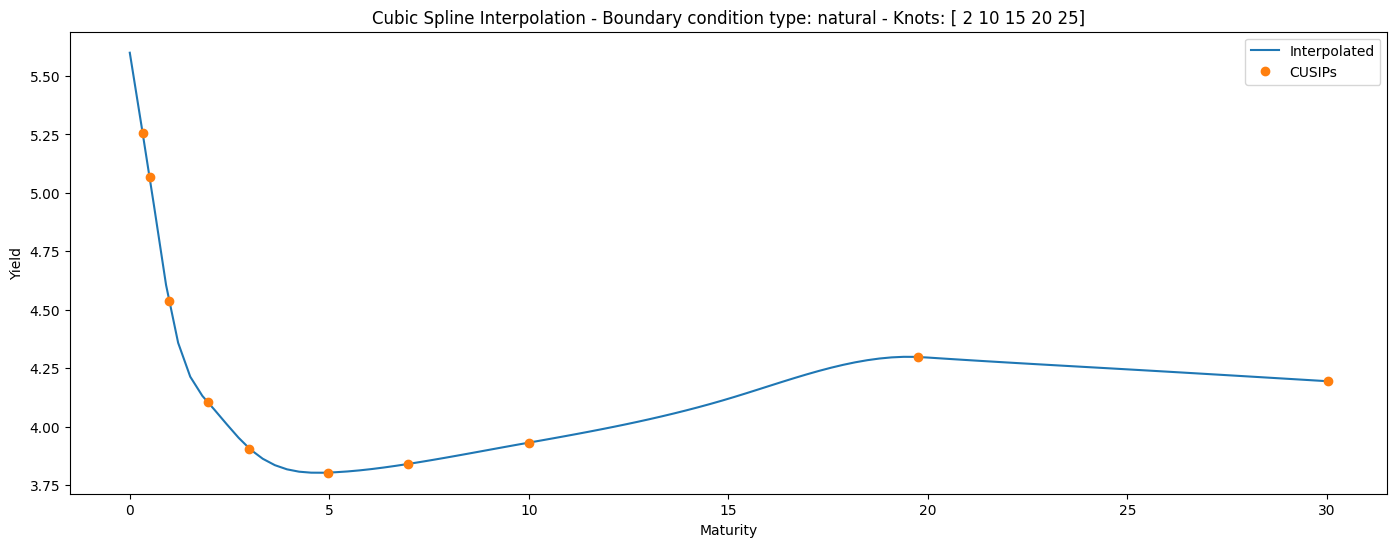

In [8]:
interpolator = CurveInterpolator(
    curve_set_df=df[df["is_on_the_run"] == True],
    linspace_x_num=100,
    enable_extrapolate_left_fill=True,
    enable_extrapolate_right_fill=True,
    use_bid_side=True
)

# interpolator.set_cubic_spline_interpolation(bc_type="natural")
interpolator.plotter(
    # linear=True, 
    # log_linear=True, 
    # cubic=True, 
    # pchip=True, 
    # akima=True, 
    # run_parallel=True,
    cubic_bc_types_n_knots=[("natural", np.array([2, 10, 15, 20, 25])),]
)